# Detecting Flu Epidemics via Search Engine Query Data
## Problem 1.1 - Understanding the Data
The csv file FluTrain.csv aggregates this data from January 1, 2004 until December 31, 2011 as follows:
- "Week" - The range of dates represented by this observation, in year/month/day format.
- "ILI" - This column lists the percentage of influenza-like illness (ILI)-related physician visits for the corresponding week.
- "Queries" - This column lists the fraction of queries that are ILI-related for the corresponding week, adjusted to be between 0 and 1 (higher values correspond to more ILI-related search queries).

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
flu_train = pd.read_csv('../data/FluTrain.csv')

Before applying analytics tools on the training set, we first need to understand the data at hand. Load "FluTrain.csv" into a data frame called flu_train. Looking at the time period 2004-2011, which week corresponds to the highest percentage of ILI-related physician visits? *Select the day of the month corresponding to the start of this week*.



In [3]:
flu_train.loc[flu_train['ILI'].idxmax()]

Week       2009-10-18 - 2009-10-24
ILI                       7.618892
Queries                        1.0
Name: 302, dtype: object

Which week corresponds to the highest percentage of ILI-related query fraction?

In [4]:
flu_train.loc[flu_train['Queries'].idxmax()]

Week       2009-10-18 - 2009-10-24
ILI                       7.618892
Queries                        1.0
Name: 302, dtype: object

## Problem 1.2 - Understanding the Data
Let us now understand the data at an aggregate level. Plot the histogram of the dependent variable, ILI. What best describes the distribution of values of ILI?

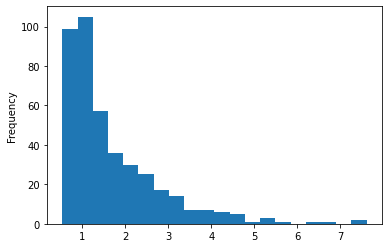

In [5]:
flu_train['ILI'].plot.hist(bins=20);

## Problem 1.3 - Understanding the Data
When handling a skewed dependent variable, it is often useful to predict the logarithm of the dependent variable instead of the dependent variable itself -- this prevents the small number of unusually large or small observations from having an undue influence on the sum of squared errors of predictive models. In this problem, we will predict the natural log of the ILI variable.

Plot the natural logarithm of ILI versus Queries. What does the plot suggest?

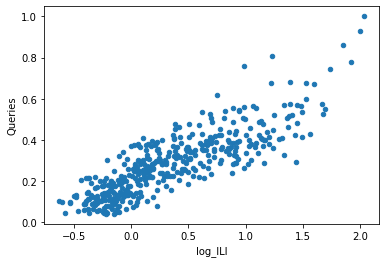

In [6]:
flu_train['log_ILI'] = np.log(flu_train['ILI'])
flu_train.plot.scatter('log_ILI', 'Queries');

## Problem 2.1 - Linear Regression Model
Based on the plot we just made, it seems that a linear regression model could be a good modeling choice. Based on our understanding of the data from the previous subproblem, which model best describes our estimation problem?
- log(ILI) = intercept + coefficient x Queries, where the coefficient is positive

## Problem 2.2 - Linear Regression Model
Let's call the regression model from the previous problem (Problem 2.1) flu_trend1 and run it in Python.

What is the training set R-squared value for flu_trend1 model (the "Multiple R-squared")?
- 0.709

In [7]:
X = flu_train[['Queries']]
y = flu_train['log_ILI']

flu_trend1 = sm.OLS(y, sm.add_constant(X)).fit()
print(flu_trend1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ILI   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     1011.
Date:                Mon, 16 Aug 2021   Prob (F-statistic):          2.62e-113
Time:                        07:50:23   Log-Likelihood:                -87.974
No. Observations:                 417   AIC:                             179.9
Df Residuals:                     415   BIC:                             188.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4993      0.030    -16.422      0.0

## Problem 2.3 - Linear Regression Model
For a single variable linear regression model, there is a direct relationship between the R-squared and the correlation between the independent and the dependent variables. What is the relationship we infer from our problem?
- R-squared = Correlation^2

In [8]:
flu_corr = flu_train[['Queries', 'log_ILI']].corr().iloc[0, 1]
print("Correlation^2:", flu_corr**2)
print("log(1/Correlation:", np.log(1/flu_corr))
print("exp(-0.5*Correlation:", np.exp(-0.5*flu_corr))

Correlation^2: 0.7090200553481852
log(1/Correlation: 0.17193573302011073
exp(-0.5*Correlation: 0.6563791770795295


## Problem 3.1 - Performance on the Test Set
The csv file FluTest.csv provides the 2012 weekly data of the ILI-related search queries and the observed weekly percentage of ILI-related physician visits. Load this data into a data frame called flu_test.

We are instead interested in obtaining predictions of the ILI value. We can convert from predictions of log(ILI) to predictions of ILI via exponentiation.

What is our estimate for the percentage of ILI-related physician visits for the week of March 11, 2012?
- 2.187

In [9]:
flu_test = pd.read_csv('../data/FluTest.csv')
flu_test['log_ILI'] = np.log(flu_test['ILI'])

X_test = flu_test[['Queries']]
y_test = flu_test['log_ILI']

y_pred = np.exp(flu_trend1.predict(sm.add_constant(X_test)))

index_num = flu_test[
    (flu_test['Week']>'2012-03-05') 
    & (flu_test['Week']<='2012-03-12')
].index[0]
y_pred.loc[index_num]

2.1873777211145455

## Problem 3.2 - Performance on the Test Set
What is the relative error betweeen the estimate (our prediction) and the observed value for the week of March 11, 2012? *Note that the relative error is calculated as:*
$$\frac{Observed ILI - Estimated ILI}{Observed ILI}$$

In [10]:
obs_ili = np.exp(y_test.loc[index_num])
est_ili = y_pred.loc[index_num]

rel_error = (obs_ili - est_ili) / obs_ili
print("Relative error:", rel_error.round(3))

Relative error: 0.046


## Problem 3.3 - Performance on the Test Set
What is the Root Mean Square Error (RMSE) between our estimates and the actual observations for the percentage of ILI-related physician visits, on the test set?

In [11]:
residue = np.exp(y_test) - y_pred
sse = (residue**2).sum()
rmse = np.sqrt(sse / flu_test.shape[0])
print("RMSE:", rmse.round(3))

RMSE: 0.749


## Problem 4.1 - Training a Time Series Model
The observations in this dataset are consecutive weekly measurements of the dependent and independent variables. This sort of dataset is called a "time series." Often, statistical models can be improved by predicting the current value of the dependent variable using the value of the dependent variable from earlier weeks. In our models, this means we will predict the ILI variable in the current week using values of the ILI variable from previous weeks.

First, we need to decide the amount of time to lag the observations. Because the ILI variable is reported with a 1- or 2-week lag, a decision maker cannot rely on the previous week's ILI value to predict the current week's value. Instead, the decision maker will only have data available from 2 or more weeks ago. We will build a variable called ILILag2 that contains the ILI value from 2 weeks before the current observation.

How many values are missing in the new ILILag2 variable?

In [12]:
flu_train['start_date'] = pd.to_datetime([x[:10] for x in flu_train['Week']])
flu_train['end_date'] = pd.to_datetime([x[-10:] for x in flu_train['Week']])

flu_train['ILILag2'] = flu_train['ILI'].shift(periods=2)
flu_train.isnull().sum().loc['ILILag2']

2

## Problem 4.2 - Training a Time Series Model
Plot the log of ILILag2 against the log of ILI. Which best describes the relationship between these two variables?
- There is a strong positive relationship between log(ILILag2) and log(ILI).

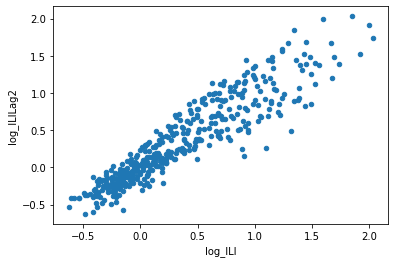

In [13]:
flu_train['log_ILILag2'] = np.log(flu_train['ILILag2'])
flu_train.plot.scatter('log_ILI', 'log_ILILag2');

## Problem 4.3 - Training a Time Series Model
Train a linear regression model on the FluTrain dataset to predict the log of the ILI variable using the Queries variable as well as the log of the ILILag2 variable. Call this model flu_trend2.

Which coefficients are significant at the p=0.05 level in this regression model? *Select all that apply.*
- Intercept
- Queries
- log(ILILag2)

What is the R^2 value of the flu_trend2 model?
- 0.906

In [14]:
features = ['log_ILILag2', 'Queries']
X = flu_train[features].loc[2:].copy()
y = flu_train['log_ILI'].loc[2:].copy()

flu_trend2 = sm.OLS(y, sm.add_constant(X)).fit()
print(flu_trend2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ILI   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     1993.
Date:                Mon, 16 Aug 2021   Prob (F-statistic):          1.38e-212
Time:                        07:50:24   Log-Likelihood:                 147.24
No. Observations:                 415   AIC:                            -288.5
Df Residuals:                     412   BIC:                            -276.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2406      0.020    -12.321      

## Problem 4.4 - Training a Time Series Model
On the basis of R-squared value and significance of coefficients, which statement is the most accurate?
- flu_trend2 is a stronger model than flu_trend1 on the training set.

## Problem 5.1 - Evaluating the Time Series Model in the Test Set
So far, we have only added the ILILag2 variable to the flu_train data frame. To make predictions with our flu_trend2 model, we will also need to add ILILag2 to the flu_test data frame (note that adding variables before splitting into a training and testing set can prevent this duplication of effort).

Modify the code from the previous subproblem to add an ILILag2 variable to the flu_test data frame. How many missing values are there in this new variable?

In [15]:
flu_test['ILILag2'] = flu_test['ILI'].shift(periods=2)
flu_test['ILILag2'].isnull().sum()

2

## Problem 5.2 - Evaluating the Time Series Model in the Test Set
In this problem, the training and testing sets are split sequentially -- the training set contains all observations from 2004-2011 and the testing set contains all observations from 2012. There is no time gap between the two datasets, meaning the first observation in FluTest was recorded one week after the last observation in FluTrain. From this, we can identify how to fill in the missing values for the ILILag2 variable in FluTest.

Which value should be used to fill in the ILILag2 variable for the first observation in FluTest?
- The ILI value of the second-to-last observation in the FluTrain data frame.

Which value should be used to fill in the ILILag2 variable for the second observation in FluTest?
- The ILI value of the last observation in the FluTrain data frame.

## Problem 5.3 - Evaluating the Time Series Model in the Test Set
Fill in the missing values for ILILag2 in FluTest.

What is the new value of the ILILag2 variable in the first row of FluTest?
- 1.853

What is the new value of the ILILag2 variable in the second row of FluTest?
- 2.124

In [16]:
flu_test.loc[0, 'ILILag2'] = flu_train.iloc[-2]['ILI']
flu_test.loc[1, 'ILILag2'] = flu_train.iloc[-1]['ILI']
flu_test.head(2)

,Week,ILI,Queries,log_ILI,ILILag2
0,2012-01-01 - 2012-01-07,1.766707,0.593625,0.569117,1.852736
1,2012-01-08 - 2012-01-14,1.543401,0.499336,0.433988,2.124130


## Problem 5.4 - Evaluating the Time Series Model in the Test Set
Obtain test set predictions of the ILI variable from the flu_trend2 model, again remembering to call the exponential on the result of the predict() function to obtain predictions for ILI instead of log(ILI).

What is the test-set RMSE of the FluTrend2 model?

In [17]:
flu_test['log_ILILag2'] = np.log(flu_test['ILILag2'])

X_test = flu_test[features].copy()
y_test = flu_test['log_ILI']

y_pred = flu_trend2.predict(sm.add_constant(X_test))
residue = np.exp(y_test) - np.exp(y_pred)
sse = (residue**2).sum()
rmse = np.sqrt(sse/X_test.shape[0])
print("RMSE for test set:", rmse.round(3))

RMSE for test set: 0.294


## Problem 5.5 - Evaluating the Time Series Model in the Test Set
Which model obtained the best test-set RMSE?
- flu_trend2